<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.3.1
GPU detected: []


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [39]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [40]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [41]:
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

In [42]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [43]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w,p,t) for w,p,t in zip(s['Word'].values.tolist(),
                                                      s['POS'].values.tolist(),
                                                      s['Tag'].values.tolist())]
        
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [44]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [45]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [46]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t:i for i,t in enumerate(tags)}

In [47]:
word2idx

{'Jaunpur': 1,
 'physical': 2,
 'Kivu': 3,
 'transparency': 4,
 'thriller': 5,
 'precipitously': 6,
 'WFP': 7,
 'depict': 8,
 'tolerance': 9,
 'run-in': 10,
 'noted': 11,
 'Berkofsky': 12,
 'infecting': 13,
 'defenses': 14,
 'onlookers': 15,
 'Already': 16,
 'Punjab': 17,
 '40th': 18,
 'AIDs': 19,
 'SIHAMONI': 20,
 'balanced': 21,
 'instigating': 22,
 'Atilla': 23,
 'Nargis': 24,
 'abiding': 25,
 'Arinze': 26,
 'benefactor': 27,
 'verification': 28,
 'A380s': 29,
 'CNBC': 30,
 'fail': 31,
 'riders': 32,
 'German-owned': 33,
 'Guirassy': 34,
 'Soltanieh': 35,
 'feather': 36,
 'Radhia': 37,
 'Diaoyu': 38,
 'Warming': 39,
 'undisclosed': 40,
 'culminated': 41,
 'Prachanda': 42,
 'serenaded': 43,
 'Kiteswere': 44,
 'Mazar-i-Sharif': 45,
 'mother-to-child': 46,
 'shake-up': 47,
 'Barcodes': 48,
 'gives': 49,
 'FDIC': 50,
 'Ein': 51,
 'cylinder': 52,
 'housekeeper': 53,
 'Lucie': 54,
 'Cerda': 55,
 'Dutch': 56,
 'shipyard': 57,
 'infection': 58,
 'bigger': 59,
 'truly': 60,
 'highest-ranking

### Task 5: Padding Input Sentences and Creating Train/Test Splits

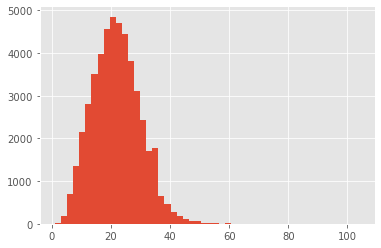

In [48]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [49]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y = [to_categorical(i,num_classes=num_tags) for i in y]


In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [51]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [52]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model =  SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.1))(model)#256
out=TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model=Model(input_word, out)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 512)           628736    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 17)            8721      
Total params: 2,396,407
Trainable params: 2,396,407
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Task 7: Train the Model

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

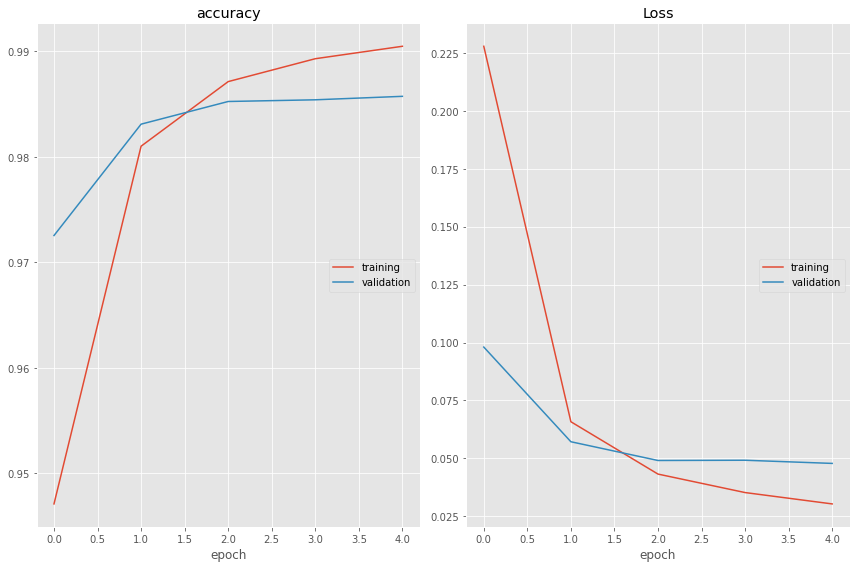

accuracy
	training         	 (min:    0.947, max:    0.990, cur:    0.990)
	validation       	 (min:    0.973, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.030, max:    0.228, cur:    0.030)
	validation       	 (min:    0.048, max:    0.098, cur:    0.048)
540/540 [==============================] - 337s 625ms/step - loss: 0.0303 - accuracy: 0.9905 - val_loss: 0.0478 - val_accuracy: 0.9857


In [55]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks= [PlotLossesCallback(), early_stopping]

history = model.fit(
X_train, np.array(y_train),
validation_split=0.2,
batch_size=64,#64
epochs=5,#5
callbacks=callbacks
    
)

### Task 8: Evaluate Named Entity Recognition Model

In [56]:
model.evaluate(X_test, np.array(y_test))

150/150 [==============================] - 19s 127ms/step - loss: 0.0489 - accuracy: 0.9856


[0.04886002093553543, 0.9856088161468506]

In [60]:
i = np.random.randint(0,X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test),axis=-1)[i]

print("{:15}{:5}\t {}\n".format("Word", "True","Pred"))
print("-"*30)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{:5}\t {}".format(words[w-1], tags[true],tags[pred]))
    

Word           True 	 Pred

------------------------------
Visiting       O    	 O
Afghan         B-gpe	 B-gpe
President      B-per	 B-per
Hamid          I-per	 I-per
Karzai         I-per	 I-per
thanked        O    	 O
Iran           B-geo	 B-geo
for            O    	 O
building       O    	 O
the            O    	 O
$              O    	 O
60             O    	 O
million        O    	 O
highway        O    	 O
and            O    	 O
emphasized     O    	 O
that           O    	 O
the            O    	 O
reconstruction O    	 O
of             O    	 O
war-torn       O    	 O
Afghanistan    B-geo	 B-geo
will           O    	 O
also           O    	 O
help           O    	 O
its            O    	 O
neighbors      O    	 O
.              O    	 O
Polytechnic    O    	 O
Polytechnic    O    	 O
Polytechnic    O    	 O
Polytechnic    O    	 O
Polytechnic    O    	 O
Polytechnic    O    	 O
Polytechnic    O    	 O
Polytechnic    O    	 O
Polytechnic    O    	 O
Polytechnic    O    	 O
Polyt